In [58]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
import random
import string

from eval import get_run_metrics, read_run_dir, get_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
df = read_run_dir(run_dir)
df  # list all the runs in our run_dir

,run_id,task,model,kwargs,num_tasks,num_examples,n_dims,n_layer,n_head,run_name
4,pretrained,decision_tree,Transformer,depth=4,-1,-1,20,12,8,decision_tree_pretrained
0,pretrained,linear_regression,Transformer,,-1,-1,20,12,8,linear_regression_pretrained
1,first-successful,linear_regression,Transformer,,-1,-1,5,12,8,linear_regression_toy
2,pretrained,relu_2nn_regression,Transformer,hidden_layer_size=100,-1,-1,20,12,8,relu_2nn_regression_pretrained
3,pretrained,sparse_linear_regression,Transformer,sparsity=3,-1,-1,20,12,8,sparse_regression_pretrained


In [60]:
task = "linear_regression"
#task = "sparse_linear_regression"
#task = "decision_tree"
#task = "relu_2nn_regression"

run_id = "first-successful"  # if you train more models, replace with the run_id from the table above

run_path = os.path.join(run_dir, task, run_id)
recompute_metrics = False

if recompute_metrics:
    # question: is this with the test set? -- i think so
    get_run_metrics(run_path)  # these are normally precomputed at the end of training

In [61]:
def save_current_figure(folder_path, file_name):
    if not os.path.exists("plots"):
        os.makedirs("plots")
    folder_path = "plots/" + folder_path
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    file_path = os.path.join(folder_path, file_name)
    plt.savefig(file_path)
    plt.close()

def generate_random_string(length=8):
    letters_and_digits = string.ascii_letters + string.digits
    random_string = ''.join(random.choice(letters_and_digits) for _ in range(length))
    return random_string

In [62]:
fig_output_dir = run_id + "_" + task + "_" + generate_random_string()

# Plot pre-computed metrics

linear_regression_toy first-successful


100%|██████████| 15/15 [00:00<00:00, 166001.48it/s]


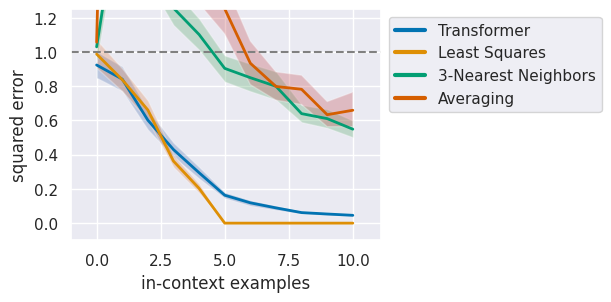

In [63]:
def valid_row(r):
    return r.task == task and r.run_id == run_id

metrics = collect_results(run_dir, df, valid_row=valid_row)
_, conf = get_model_from_run(run_path, only_conf=True)
n_dims = conf.model.n_dims

models = relevant_model_names[task]
basic_plot(metrics["standard"], models=models)
plt.show()
save_current_figure(fig_output_dir, "eval_on_all_models")

# questions: 
# is it just one transformer layer?, no it's 12 layers with 8 heads, but you can change the size
# where are the in context examples being generated? -- i believe using the data sampler
# is this on training squared error? or where is the evaluation done? -- yea, probably 

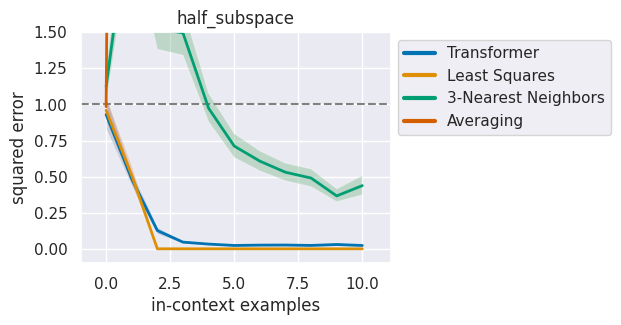

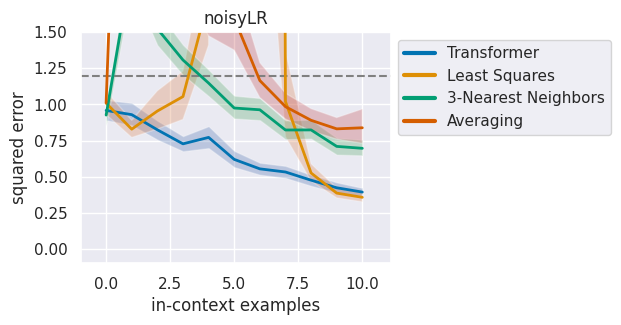

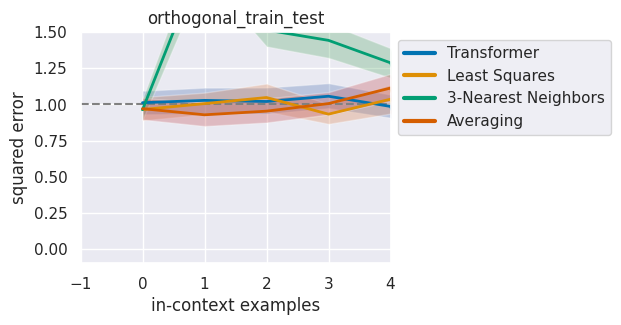

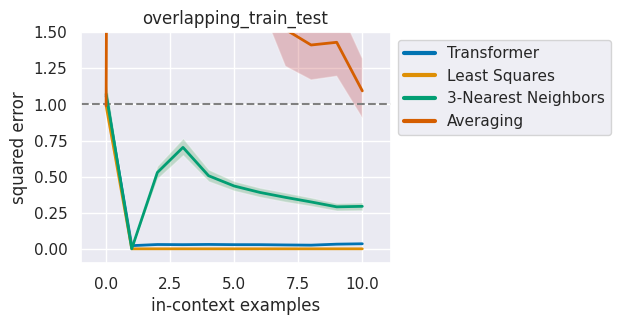

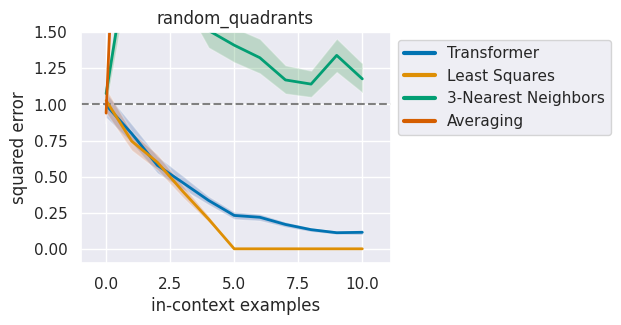

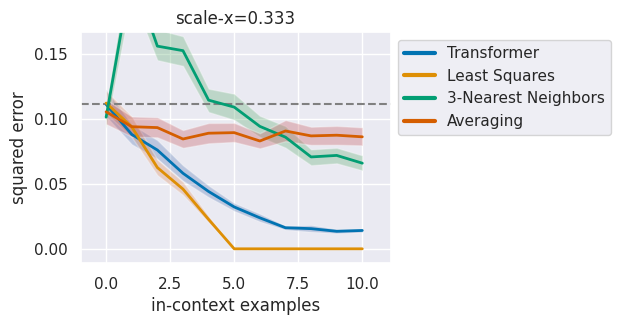

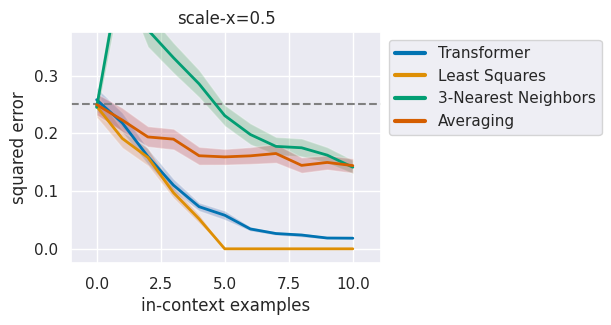

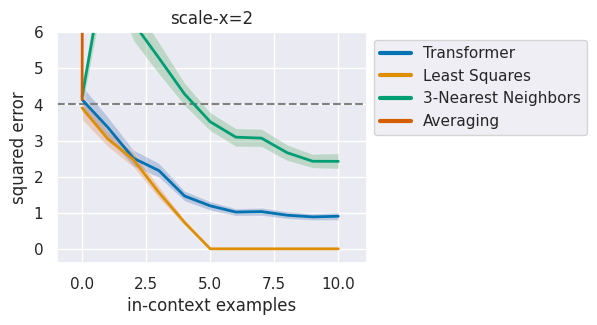

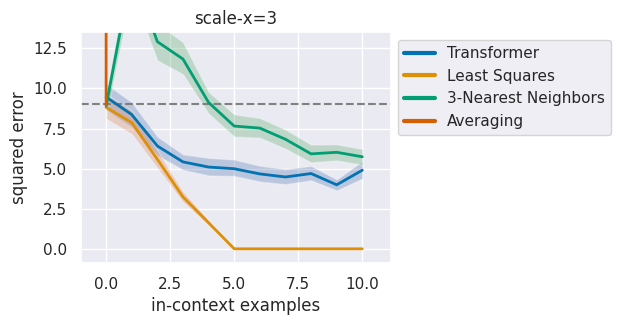

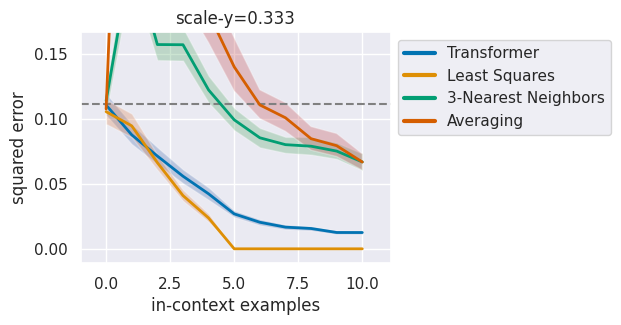

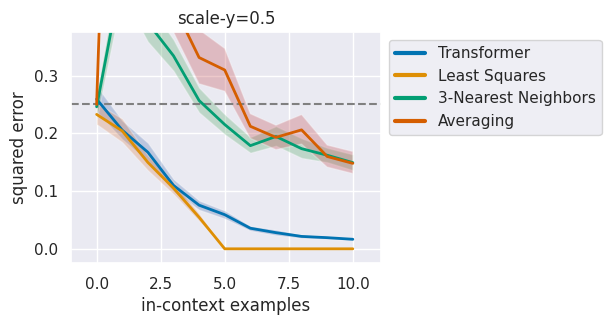

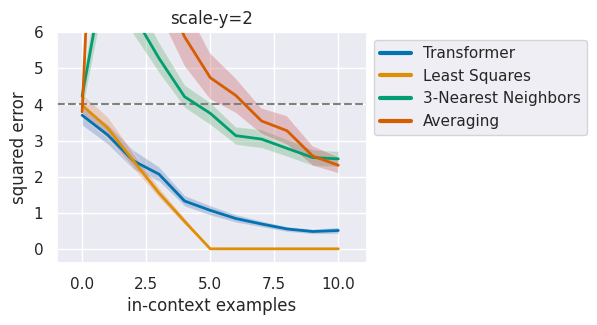

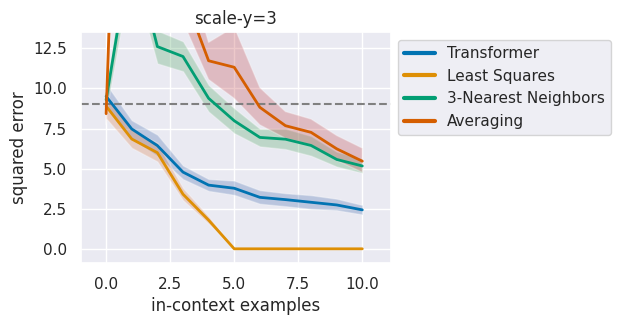

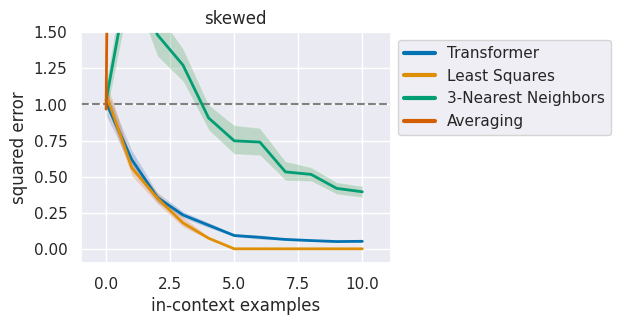

In [64]:
# plot any OOD metrics, out of distribution
for name, metric in metrics.items():
    if name == "standard": continue
   
    if "scale" in name:
        scale = float(name.split("=")[-1])**2
    else:
        scale = 1.0

    trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    ax.set_title(name)
    
    if "ortho" in name:
        ax.set_xlim(-1, n_dims - 1)
    ax.set_ylim(-.1 * scale, 1.5 * scale)

    plt.show()
    if ("." in name):
        name = name.replace(".", "")
    save_current_figure(fig_output_dir, "eval_on_all_models_ood_" + name)

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [65]:
from samplers import get_data_sampler
from tasks import get_task_sampler

In [66]:
model, conf = get_model_from_run(run_path)

n_dims = conf.model.n_dims
batch_size = conf.training.batch_size

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    conf.training.task,
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [67]:
def generate_random_ys(num_changes, num_total, y_dim):
    """
    Selects num_changes random indices from the range 0 to num_total - 1.

    Args:
    - num_total (int): Total number of indices.
    - num_changes (int): Number of random indices to select.
    - y_dim (int): Dimension of every y value

    Returns:
    - torch.Tensor: Tensor containing the selected random indices. (of length num_changes)
    - torch.Tensor: Tensor containing the new random values at those indices
    """

    if num_changes > num_total:
        raise ValueError("Number of changes cannot be greater than the total number.")
    
    # Generate random indices
    random_indices = torch.randint(0, num_total, (num_changes,), dtype=torch.long)
    indices_values = random_tensors = torch.rand((num_changes, y_dim))

    return random_indices, indices_values
    

In [68]:
# are the xs the prompts, containing the query, and are the ys the evaluations of the query?
# or, since x and y are concatenated for eval, are the xs and ys parts of the input?
# if it's the first one, we need to change our code
# if it's the second one, we need to find the query

task = task_sampler()
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
ys = task.evaluate(xs)

print(ys.shape)

num_indices = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64]
randomized_ys_array = []

for num_changes in num_indices:
    randomized_ys = ys.clone()
    random_indices, indices_values = generate_random_ys(num_changes, randomized_ys.shape[0], randomized_ys.shape[1])
    randomized_ys[random_indices] = indices_values

    randomized_ys_array.append(randomized_ys)

# randomly select some indices out of the 64, access them and then set their values to be drawn from a random normal distribution

torch.Size([64, 11])


In [69]:
# why does the model take in xs and ys? -- it creates the sequence for u?
# i also think the prediction is for every x, even the xs that have context ?? 
# are there any xs that do not have context?

with torch.no_grad():
    pred = model(xs, ys)
    print(pred.shape)

randomized_pred_array = []
for randomized_ys in randomized_ys_array:
    with torch.no_grad():
        randomized_pred = model(xs, randomized_ys)
        randomized_pred_array.append(randomized_pred)

tensor([1.6926, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch.Size([64, 22, 256])
torch.Size([64, 11])
tensor([1.6926, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch.Size([64, 22, 256])
tensor([1.6926, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch.Size([64, 22, 256])
tensor([1.6926, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch.Size([64, 22, 256])
tensor([1.6926, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch.Size([64, 22, 256])
tensor([1.6926, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch.Size([64, 22, 256])
tensor([1.6926, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch.Size([64, 22, 256])
tensor([1.6926, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch

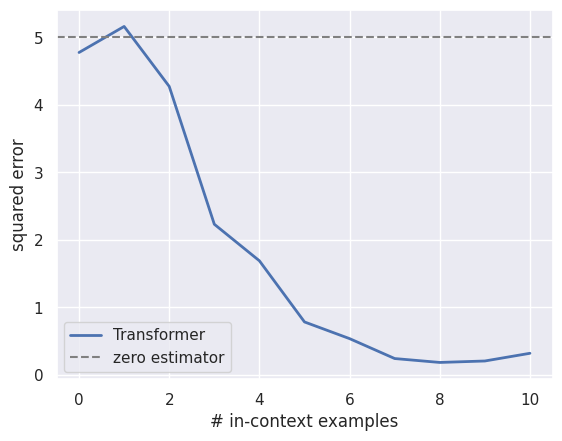

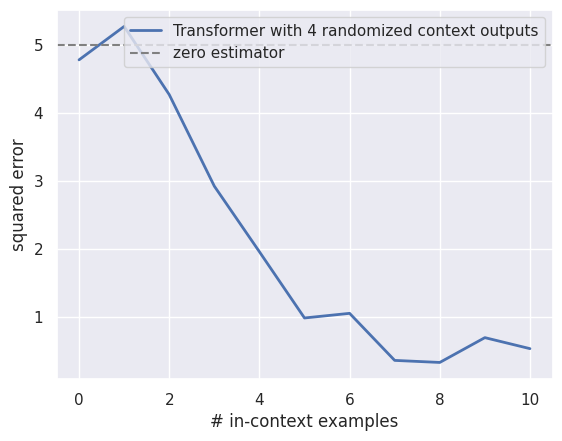

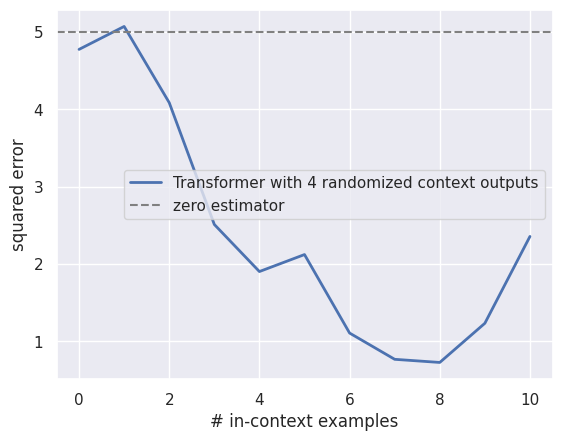

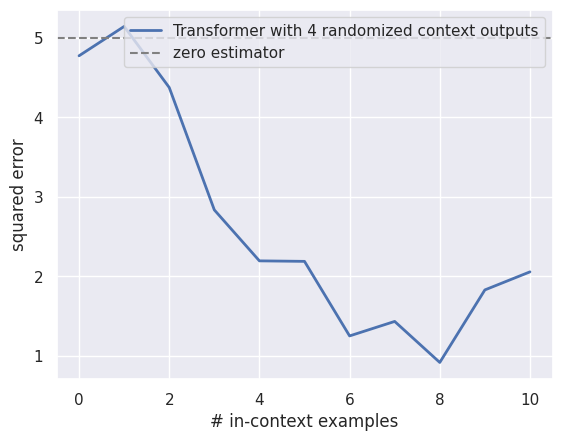

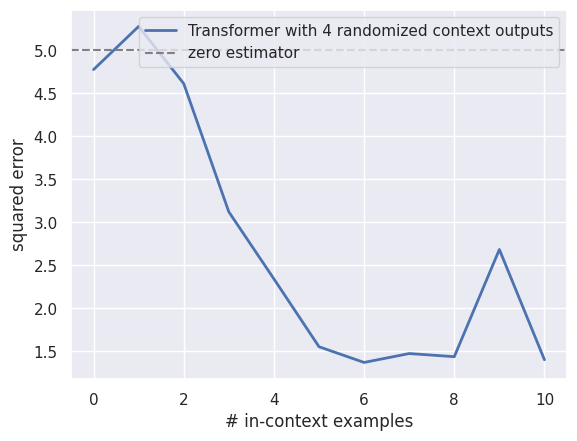

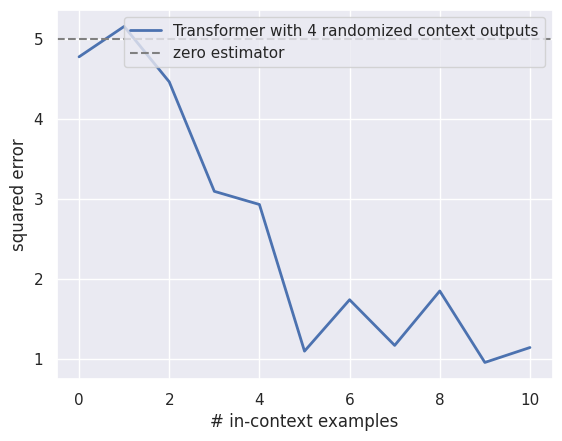

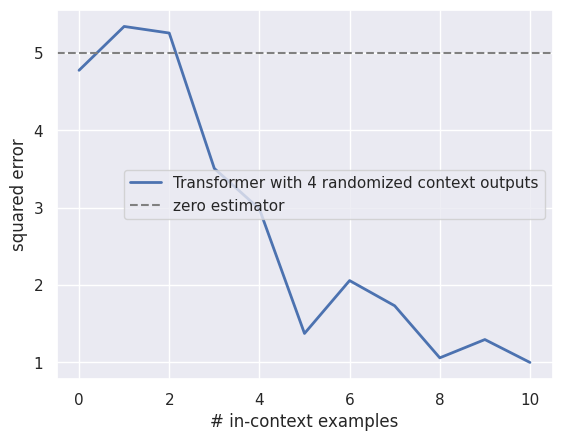

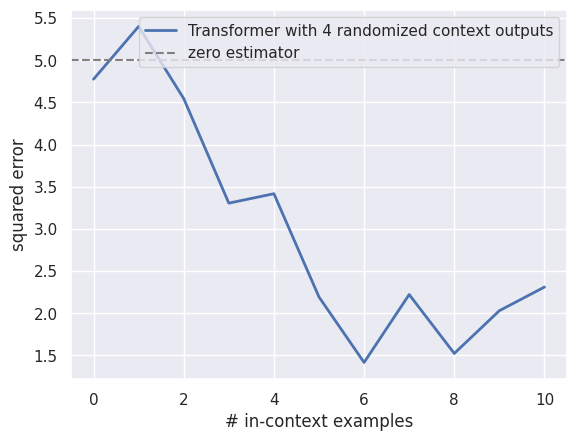

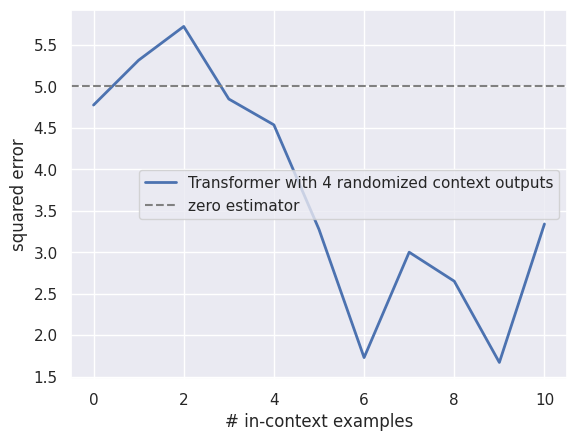

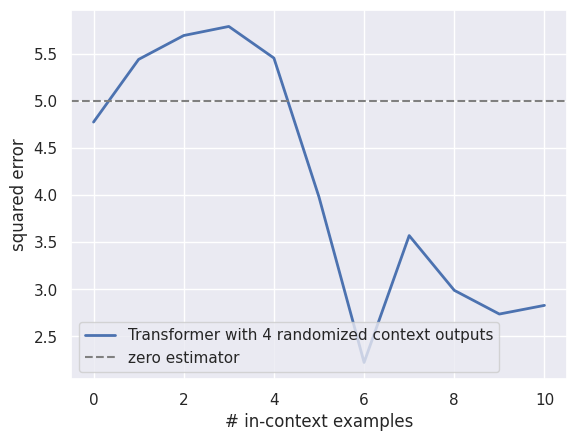

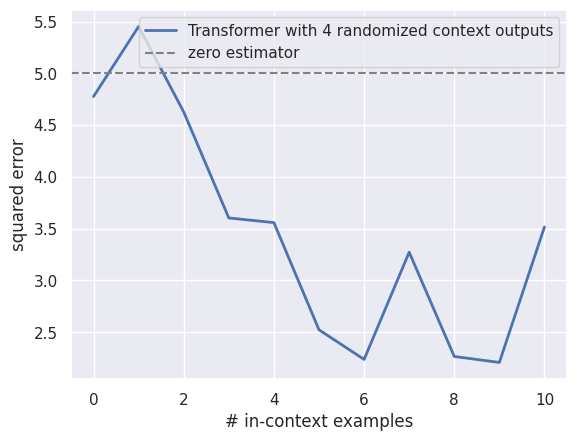

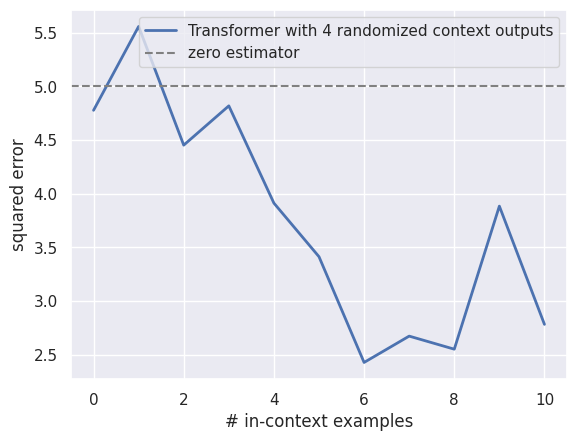

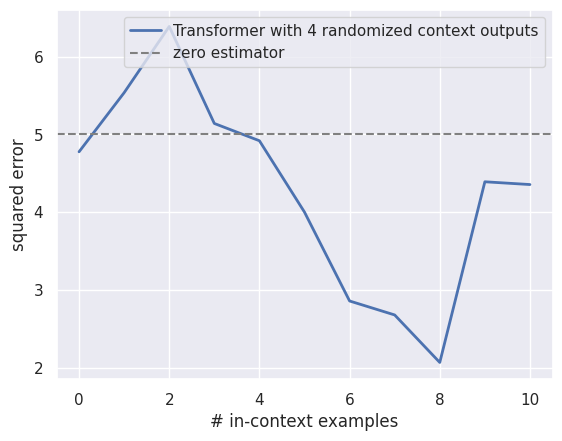

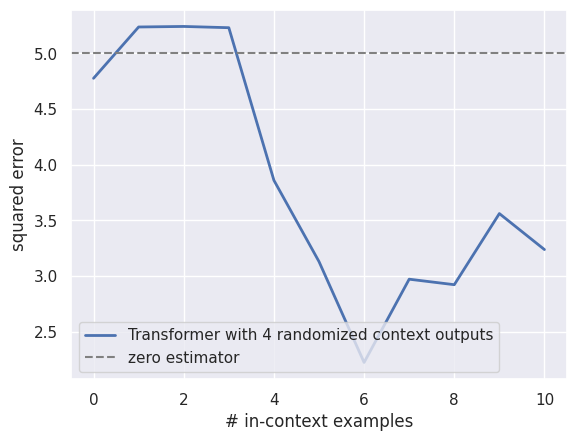

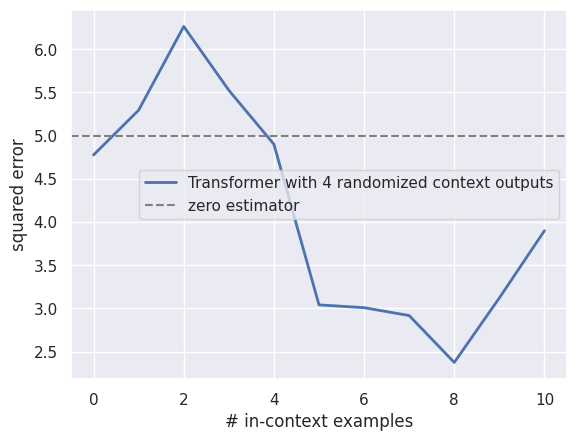

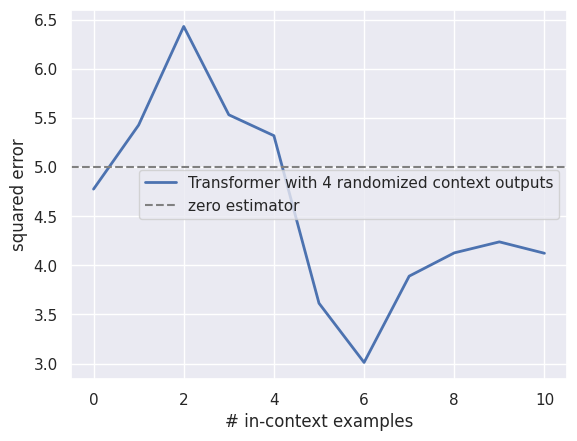

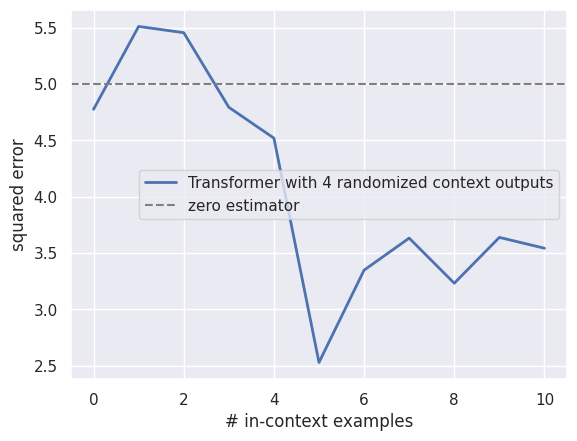

In [70]:
# it seems like the metric is just subtracting the predictions from the ys, but im confused because are the ys not like passed in as context?
metric = task.get_metric()
loss = metric(pred, ys).numpy()
randomized_loss = metric(randomized_pred, ys).numpy()
# randomized_loss_w_random = metric(randomized_pred, randomized_ys).numpy()

sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf.training.task]

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()
save_current_figure(fig_output_dir, "eval_on_transformer")

num_random = 4

for randomized_pred in randomized_pred_array:
    randomized_loss = metric(randomized_pred, ys).numpy()
    
    plt.plot(randomized_loss.mean(axis=0), lw=2, label="Transformer with " + str(num_random) +  " randomized context outputs")
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()
    save_current_figure(fig_output_dir, "eval_on_transformer_" + str(num_random) + "_randomized_context")

    

# plt.plot(randomized_loss_w_random.mean(axis=0), lw=2, label="Transformer with randomized context")
# plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
# plt.xlabel("# in-context examples")
# plt.ylabel("squared error")
# plt.legend()
# plt.show()

As an exploration example, let's see how robust the model is to doubling all the inputs.

In [71]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)
with torch.no_grad():
    pred2 = model(xs2, ys2)

tensor([3.3853, 0.0000, 0.0000, 0.0000, 0.0000])
torch.Size([64, 22, 5])
torch.Size([64, 22, 256])
torch.Size([64, 22, 256])


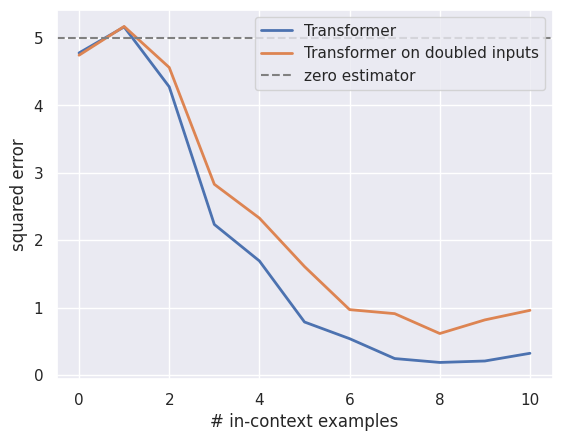

In [72]:
loss2 = metric(pred2, ys2).numpy()

plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
plt.plot(loss2.mean(axis=0) / 4, lw=2, label="Transformer on doubled inputs")
plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()
save_current_figure(fig_output_dir, "eval_on_transformer_with_doubled_inputs")

The error does increase, especially when the number of in-context examples exceeds the dimension, but the model is still relatively accurate.